In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# **Data Reading**

In [2]:
train_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [3]:
test_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


# **Exploratory data analysis**

In [4]:
train_data.isna().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [5]:
test_data.isna().sum()

Id             0
Title          0
Description    0
dtype: int64

In [6]:
train_data.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [7]:
test_data.describe()

,Id
count,54200.000000
mean,27100.500000
std,15646.336632
min,1.000000
25%,13550.750000
50%,27100.500000
75%,40650.250000
max,54200.000000


**Counting movies based on their genre**

In [8]:
class_distribution = train_data['Genre'].value_counts()
class_distribution

Genre
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

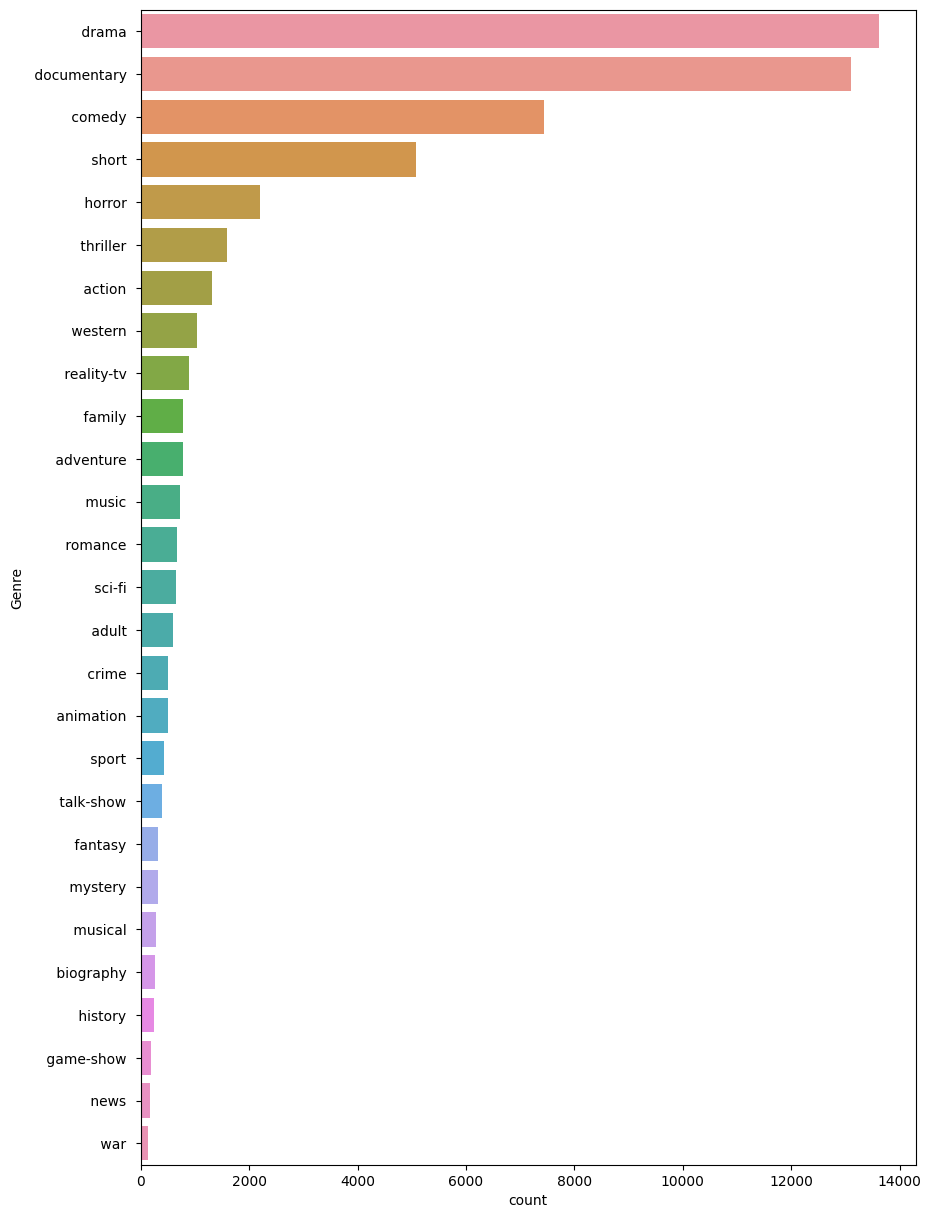

In [9]:
plt.figure(figsize=(10,15))
sns.countplot(data=train_data, y="Genre", order= train_data["Genre"].value_counts().index)
plt.show()

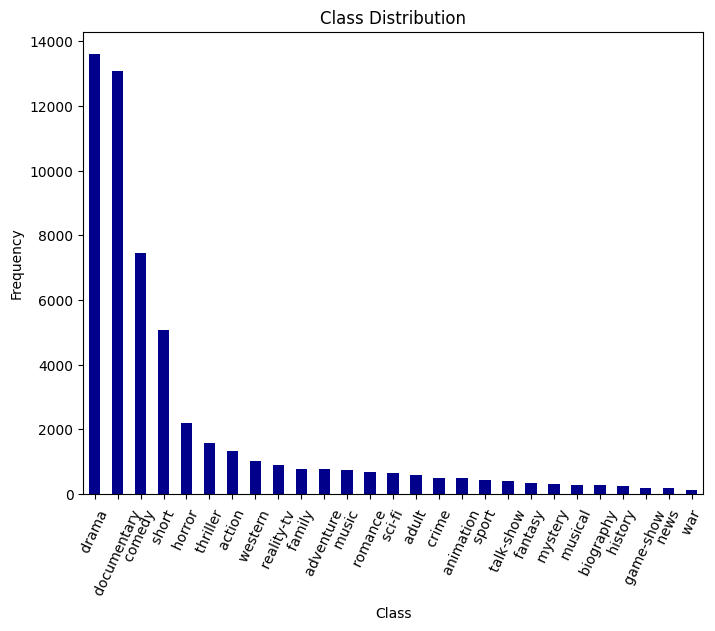

In [10]:
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color='darkblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=65)
plt.show()

# Data Preprocessing

In [11]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [12]:
train_data.head()

,Title,Genre,Description,Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...


In [13]:
test_data.head()

,Id,Title,Description,Text_cleaning
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...


# Vectorizing data

In [14]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

# Spliting data into train data and test data

In [15]:
X = X_train
y = train_data['Genre']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Model

In [16]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.44526422576777647


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.61      0.04      0.07      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.00      0.00      0.00        56
        n

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Use the trained model to make predictions on the test data
X_test_predictions = classifier.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

In [18]:
test_data.to_csv('predicted_genres.csv', index=False)

In [19]:
print(test_data)

          Id                             Title  \
0          1             Edgar's Lunch (1998)    
1          2         La guerra de papá (1977)    
2          3      Off the Beaten Track (2010)    
3          4           Meu Amigo Hindu (2015)    
4          5                Er nu zhai (1955)    
...      ...                               ...   
54195  54196   "Tales of Light & Dark" (2013)    
54196  54197      Der letzte Mohikaner (1965)    
54197  54198              Oliver Twink (2007)    
54198  54199                Slipstream (1973)    
54199  54200        Curitiba Zero Grau (2010)    

                                             Description  \
0       L.R. Brane loves his life - his car, his apar...   
1       Spain, March 1964: Quico is a very naughty ch...   
2       One year in the life of Albin and his family ...   
3       His father has died, he hasn't spoken with hi...   
4       Before he was known internationally as a mart...   
...                                    